# Assignment4

### 1

For each of the shap_features in the files in the folders Random Forest Parameters and Gradient Boosting Parameters, find the 10 most common features and use those as the optimal features.

Find the P/L curves and compute annualized Sharp Ratios

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import lightgbm as lgb
pd.set_option('use_inf_as_na', True)
import pickle

import optuna
from optuna.trial import Trial
import optuna.integration.lightgbm as lgb


from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation

import sklearn.datasets
from sklearn.model_selection import train_test_split

from functools import partial

In [2]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [3]:
raw_data = pd.read_pickle(r'dataset.pkl')
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0,inplace=True)

In [4]:
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [5]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [6]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = StandardScaler()

In [7]:
shap_features_rf = pd.read_pickle(r'shap_features.pkl')

In [8]:
from collections import Counter

In [9]:
shap_features_list_rf = [item for sublist in shap_features_rf for item in sublist]
shap_features_rf_items = Counter(shap_features_list_rf)
shap_features_rf = [x[0] for x in Counter(shap_features_list_rf).most_common(10)]
shap_features_rf

['fcf_yield',
 'cf_yield',
 'oancfy',
 'oancfy_q',
 'fcf_csfhdq',
 'lt_ppentq',
 'evmq',
 'dprq',
 'oepsxy',
 'dvpspq']

In [10]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [11]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d:d+pd.DateOffset(months = 3)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 6):d+pd.DateOffset(months = 9)] for d in end_dates]

In [12]:
drops = ['ticker','date',
        'next_period_return',
       'spy_next_period_return',
       'rel_performance','pred_rel_return',
          'return', 'cum_ret', 'spy_cum_ret']

In [13]:
training_data = [d.reset_index().drop(drops,axis=1) for d in training_frames]
valid_data = [d.reset_index().drop(drops,axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(drops,axis=1) for d in test_frames]

In [14]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [15]:
with open(r'optimal_hyperparameters.pkl','rb') as f:
    optimal_hyperparameters = pickle.load(f)

In [16]:
classifiers_rf = []
for hyp_par in optimal_hyperparameters:
    rf_clf = RandomForestClassifier(**hyp_par)
    classifiers_rf.append(rf_clf)

In [17]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 39) for d in start_dates]

training_frames = [data.loc[d:d+pd.DateOffset(months = 39)] for d in start_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]

training_labels = [d['rel_performance'].values for d in training_frames]

In [18]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_rf]),columns=shap_features_rf) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_rf]),columns=shap_features_rf) for i in range(len(start_dates)-1)]

In [19]:
x_rf = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers_rf[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers_rf[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x_rf.append(x_rf[i] + (x_rf[i]/num_names)*profit_i)

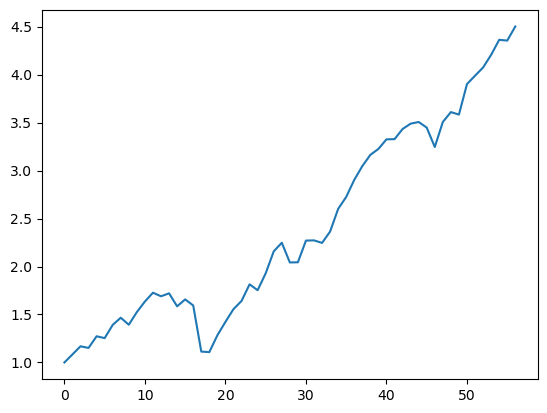

In [20]:
plt.plot(x_rf);

In [21]:
shap_features_gb = pd.read_pickle('shap_features_gb_clf_01.pkl')

In [22]:
shap_features_list_gb = [item for sublist in shap_features_gb for item in sublist]
shap_features_gb_items = Counter(shap_features_list_gb)
shap_features_gb = [x[0] for x in Counter(shap_features_list_gb).most_common(10)]
shap_features_gb

['cf_yield',
 'fcf_yield',
 'evmq',
 'dvpspq',
 'rect_turnq',
 'lt_ppentq',
 'debt_assetsq',
 'oepsxy',
 'dprq',
 'fcf_ocfq']

In [ ]:
with open(r'classifiers_gb_clf_01.pkl','rb') as f:
    classifiers_gb = pickle.load(f)

In [24]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [pd.DataFrame(scalers[i].fit_transform(training_frames[i][shap_features_gb]),columns=shap_features_gb) for i in range(len(start_dates)-1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][shap_features_gb]),columns=shap_features_gb) for i in range(len(start_dates)-1)]

In [25]:
training_labels = [d['rel_performance'].values for d in training_frames]

In [26]:
x_gb = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers_gb[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers_gb[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x_gb.append(x_gb[i] + (x_gb[i]/num_names)*profit_i)

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=2400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1600
[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
[LightGBM] [Warning] min_data_in_leaf is set=1600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=160

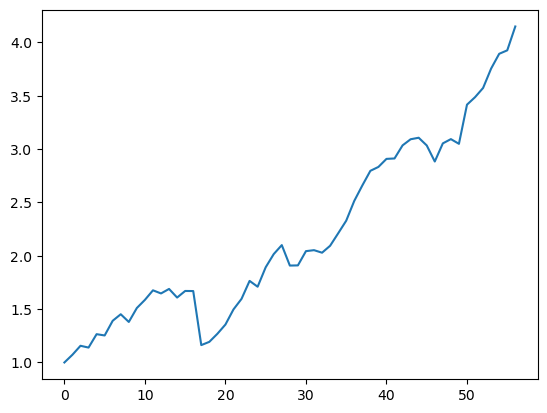

In [27]:
plt.plot(x_gb);

In [28]:
SPY = pd.read_pickle(r'SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy_random_forest'] = x_rf
SPY['strategy_gradient_boosting'] = x_gb

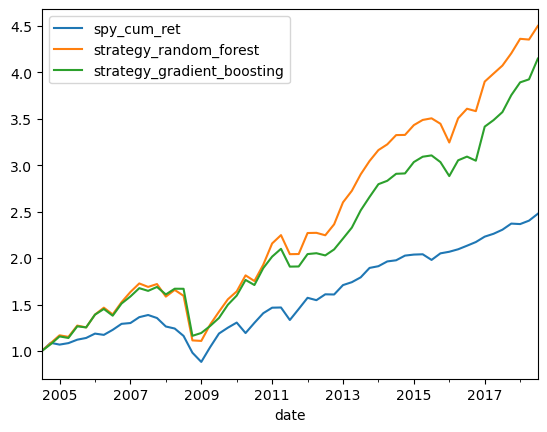

In [29]:
SPY.plot();

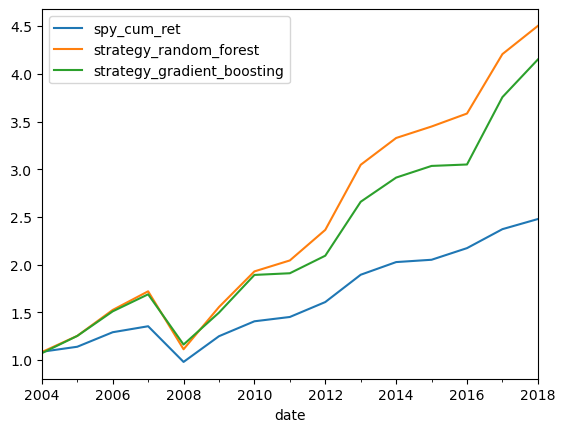

In [30]:
SPY = SPY.resample('Y').ffill()
SPY.plot();

In [31]:
def SharpeRatio(ret):
    strategy_mean_ret = (ret - 1).diff().mean()
    strategy_std = (ret - 1).diff().std()
    strategy_sr = strategy_mean_ret/strategy_std
    return strategy_sr

SharpeRatio(SPY)

spy_cum_ret                   0.632465
strategy_random_forest        0.810821
strategy_gradient_boosting    0.760341
dtype: float64

### 2
Combine these strategies, by choosing weights on each strategy and try to find a combined strategy with the best Sharp Ratio. You can also try to include a short of the SPY by including SPY with a negative weight.

In [32]:
import random

In [33]:
rf = SPY['strategy_random_forest']
gb = SPY['strategy_gradient_boosting']
spy = SPY['spy_cum_ret']

def findbestweight(loop_num,weight_lower_bound,weight_upper_bound):
    sr_max = 0
    optimal_w_rf,optimal_w_gb,optimal_w_spy=1,0,0
    for i in range(loop_num):
        w_rf=random.uniform(weight_lower_bound,weight_upper_bound) 
        w_gb=random.uniform(weight_lower_bound,weight_upper_bound) 
        w_spy=1-w_rf-w_gb
        hedge_ret = w_rf*rf + w_gb*gb + w_spy*spy
        sr_temp = SharpeRatio(hedge_ret)
        if sr_temp > sr_max:
            sr_max = sr_temp
            optimal_w_rf = w_rf
            optimal_w_gb = w_gb
            optimal_w_spy = w_spy
    return {'sr_max':sr_max,'w_rf':optimal_w_rf,'w_gb':optimal_w_gb,'w_spy':optimal_w_spy}

In [34]:
findbestweight(1000,-2,2)


{'sr_max': 0.8564963867928382,
 'w_rf': 1.9754258097298885,
 'w_gb': 0.4273235522439145,
 'w_spy': -1.402749361973803}

<AxesSubplot:xlabel='date'>

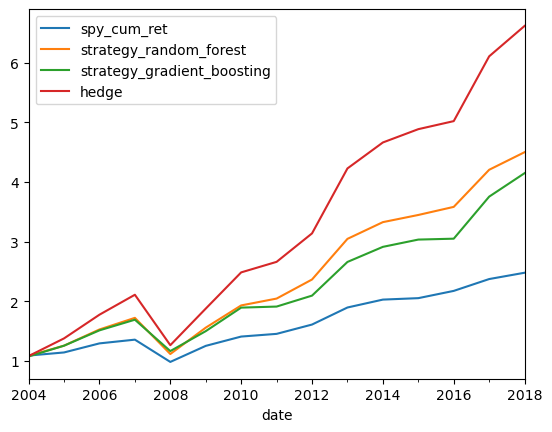

In [35]:
SPY['hedge']=1.94*rf + 0.13*gb - 1.07*spy

SPY.plot()

In [36]:
SharpeRatio(SPY)

spy_cum_ret                   0.632465
strategy_random_forest        0.810821
strategy_gradient_boosting    0.760341
hedge                         0.856396
dtype: float64